In [2]:
# libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.svm import LinearSVC, SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier


from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

import pickle

In [3]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [4]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [5]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [107]:
TM1 = pd.read_csv('Titanic/Results/Stacking/1-titanic-eda-and-feature-engineering.csv')
TM2 = pd.read_csv('Titanic/Results/Stacking/2-top-1-titanic-solution.csv')
TM3 = pd.read_csv('Titanic/Results/Stacking/3-introduction-to-ensembling-techniques.csv')
TM4 = pd.read_csv('Titanic/Results/Stacking/4-stacked-classifier-top-10-on-lb.csv')
TM5 = pd.read_csv('Titanic/Results/Stacking/5-ultimate-titanic-guide-for-beginners.csv')
AM0 = pd.read_csv('AdultNoteBook/Results/Stacking/0-income-classification-using-meta-learning.csv')

from sklearn.neural_network import MLPClassifier
from sklearn.svm import NuSVC, SVC

In [113]:
TM2_Model = 

('Titanic/Results/Stacking/2-top-1-titanic-solution.pkl')
TM1_Model = pd.read_pickle('Titanic/Results/Stacking/1-titanic-eda-and-feature-engineering.pkl')
TM3_Model = pd.read_pickle('Titanic/Results/Stacking/3-introduction-to-ensembling-techniques.pkl')
TM4_Model = pd.read_pickle('Titanic/Results/Stacking/4-stacked-classifier-top-10-on-lb.pkl')
AM0_Model = pd.read_pickle('AdultNoteBook/Results/Stacking/0-income-classification-using-meta-learning.pkl')
estimators = list(AM0_Model.named_estimators_.items())

In [125]:
#TM2_Model.named_estimators_
estimators = [('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)), ('ET', ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42)), ('GB', GradientBoostingClassifier(learning_rate=0.05, min_samples_split=9,
                           n_estimators=200, random_state=42, subsample=0.9)), ('RF', RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=200,
                       random_state=42)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)), ('LGBM', LGBMClassifier(learning_rate=0.05, num_leaves=25, random_state=42,
               subsample=0.9))]
[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)), ('ET', ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42)), ('GB', GradientBoostingClassifier(learning_rate=0.05, min_samples_split=9,
                           n_estimators=200, random_state=42, subsample=0.9)), ('RF', RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=200,
                       random_state=42)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)), ('LGBM', LGBMClassifier(learning_rate=0.05, num_leaves=25, random_state=42,
               subsample=0.9))]
print(estimators)

print(estimators)


[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)), ('ET', ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42)), ('GB', GradientBoostingClassifier(learning_rate=0.05, min_samples_split=9,
                           n_estimators=200, random_state=42, subsample=0.9)), ('RF', RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=200,
                       random_state=42)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=

In [126]:
## Data

data_orig_train = pd.read_pickle('AdultNoteBook/Results/Stacking/0-income-classification-using-meta-learning_Train.pkl')
data_orig_test = pd.read_pickle('AdultNoteBook/Results/Stacking/0-income-classification-using-meta-learning_Test.pkl')
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()





In [129]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import StackingClassifier

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    print(list_estimators)
    model = StackingClassifier(estimators = list_estimators) #stack_method = 'predict_proba')
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[('LR', LogisticRegression(C=10, random_state=42))]
[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42))]
[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42))]
[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)), ('ET', ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42))]
[('LR', LogisticRegression(C=10, random_state=42)), ('SVC', SVC(C=2, gamma=0.1, random_state=42)), ('AB', AdaBoostClassifier(learning_rate=0.1, n_estimators=500, random_state=42)), ('ET', ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42)), ('GB', GradientBoostingClassifier(learning_rate=0.05, min_samples_split=9,
                           n_estimators=200, random_state=42, subsa

In [130]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()

acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
#final_result.to_csv('../../Results/Stacking/' + nb_fname + '.csv')
final_result

,classifier,T0,T1,T2,T3,T4,T5,T6,T7
accuracy,0.847886,0.842768,0.843177,0.843382,0.846965,0.847886,0.847886,0.848705,0.847886
f1,0.654740,0.633413,0.630665,0.630970,0.656874,0.658548,0.654740,0.655799,0.654740
statistical_parity_difference,-0.095756,-0.192009,-0.169377,-0.166105,-0.116623,-0.104538,-0.095756,-0.078892,-0.095756
equal_opportunity_difference,0.089907,0.140489,0.126646,0.125074,0.105168,0.098925,0.092466,0.079918,0.089907
average_abs_odds_difference,0.296412,0.228252,0.239839,0.240138,0.276968,0.280379,0.284197,0.307818,0.296412
disparate_impact,-2.102478,-2.035676,-2.024736,-2.025251,-2.115098,-2.118875,-2.102478,-2.103948,-2.102478


In [136]:
xgb = ExtraTreesClassifier(max_depth=12, min_samples_split=9, random_state=42)
from sklearn.metrics import accuracy_score, f1_score

In [137]:
mdl = xgb.fit(X_train, y_train)
yy = mdl.predict(X_test)
print("accuracy", accuracy_score(y_test, yy))
print("score", f1_score(y_test, yy))
fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
fair_list = fair.iloc[1].tolist()
print(fair_list)

accuracy 0.8492169106356843
score 0.6423889293517845
[-0.17153645813843132, -0.10819184947220944, 0.09065043151766373, 0.2778690417364108, 0.12877159552752696]


In [ ]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
#print(final_result)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/XGBoost/' + nb_fname + '.csv')
final_result


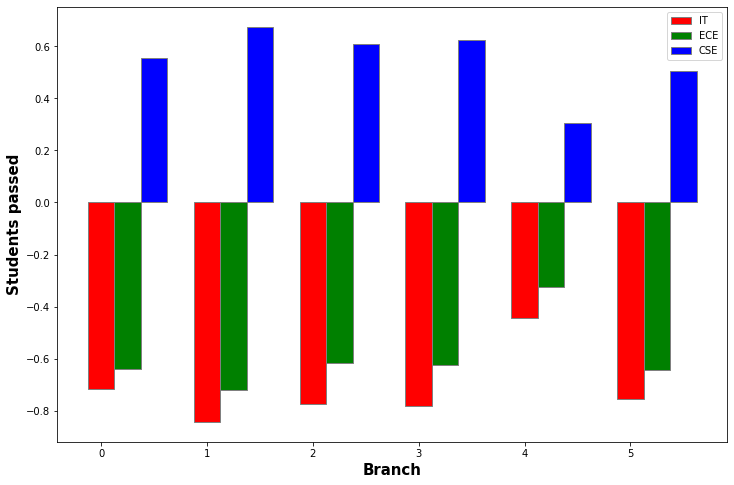

In [142]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
spd = [-0.71687, -0.84346,-0.77323,-0.78065,-0.44565,-0.75554]
eod = [-0.63854,-0.72,-0.61667,-0.62286,-0.32605,-0.64516]

aod = [0.554231, 0.675373, 0.609903, 0.625369, 0.304356, 0.504019]



 
# Set position of bar on X axis
br1 = np.arange(len(spd))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, spd, color ='r', width = barWidth,
        edgecolor ='grey', label ='IT')
plt.bar(br2, eod, color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE')
plt.bar(br3, aod, color ='b', width = barWidth,
        edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
#plt.xticks([r + barWidth for r in range(len(spd))],
 
plt.legend()
plt.show()